# Libreries

In [1]:
# Load libreries
#from google.colab import drive
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import ImageOps, Image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

#drive.mount('/content/drive')

In [2]:
tf.__version__

'2.6.0'

# Color information

In [3]:
# From color_info.txt -> https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py#L52-L99

# Class names
names = ['unlabeled', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall',
         'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
         'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']

# Class colors
colors = np.array([(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), 
          (102, 102, 156), (190, 153, 153), (180, 165, 180), (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), 
          (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), ( 0, 0, 142), ( 0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), (119, 11, 32), 
          (0, 0, 142)], dtype = np.int32)

# Class info
pd.DataFrame({'Names': names, 'Colour': [col for col in colors]})

,Names,Colour
0,unlabeled,"[0, 0, 0]"
1,dynamic,"[111, 74, 0]"
2,ground,"[81, 0, 81]"
3,road,"[128, 64, 128]"
4,sidewalk,"[244, 35, 232]"
5,parking,"[250, 170, 160]"
6,rail track,"[230, 150, 140]"
7,building,"[70, 70, 70]"
8,wall,"[102, 102, 156]"
9,fence,"[190, 153, 153]"


# Load and preprocess

In [4]:
# Define paths
train_images_folder_path = "./Train_data/Images"  #"/content/drive/My Drive/TFM/Train_data/Images"
train_mask_folder_path = "./Train_data/Labels"  #"/content/drive/My Drive/TFM/Train_data/Labels"
val_images_folder_path = "./Validation_data/Images"  #"/content/drive/My Drive/TFM/Validation_data/Images"
val_mask_folder_path = "./Validation_data/Labels"  #"/content/drive/My Drive/TFM/Validation_data/Labels"

# Get images and masks names
train_images_names = sorted([img for img in os.listdir(train_images_folder_path) if img.endswith('.png')])
train_mask_names = sorted([img for img in os.listdir(train_mask_folder_path) if img.endswith('.png')])
val_images_names = sorted([img for img in os.listdir(val_images_folder_path) if img.endswith('.png')])
val_mask_names = sorted([img for img in os.listdir(val_mask_folder_path) if img.endswith('.png')])

# Count
print(f'Train images: {len(train_images_names)}')
print(f'Train labels: {len(train_mask_names)}')
print(f'Validation images: {len(val_images_names)}')
print(f'Validation labels: {len(val_mask_names)}')

Train images: 2975
Train labels: 2975
Validation images: 500
Validation labels: 500


In [5]:
# Define image shape. Images are 1024 x 2048 (height x width) -> (896) 768 x 2048 after the crop, so to maintain the ratio: 
img_height, img_width = 96, 256  #112, 256
batch_size = 32

def one_hot_mask(y):
    ''' Do the one hot encoding for the masks.
  
    Arguments:
        - y (tf tensor): Mask of shape (height, width, 3)

    Returns:
        - mask (tf tensor): Mask after do the one hot. Shape (height, width, num_classes) '''

    one_hot_map = []
    for color in colors:
        class_map = tf.reduce_all(tf.equal(y, color), axis = -1)
        one_hot_map.append(class_map)
    mask = tf.cast(tf.stack(one_hot_map, axis = -1), tf.int32)
    return mask



def load_image(folder, file, height = 96, width = 256, crop = True):
    ''' Load and preprocess a train image by:
        - Crop the image to not have the Mercedes-Benz star
        - Resize the image to (height, width)
        - Normalize the image to [0, 1]
  
    Arguments:
        - folder (string): Path to the folder
        - file (string): Name of the file to load
        - height (int): Height to resize -- 96
        - width (int): Width to resize -- 256
        - crop (bool): Crpo the image or not -- True

    Returns:
        - image (tf tensor): Preprocessed image '''

    # Load the image (png)
    image = tf.io.read_file(folder + '/' + file)
    image = tf.cast(tf.image.decode_png(image, channels = 3), tf.float32)

    # Crop the image
    if crop:
        image = tf.image.crop_to_bounding_box(image, 0, 0, 768, 2048)

    # Resize the image
    image = tf.image.resize(image, (height, width))

    # Normalize the image
    image = tf.cast(image, tf.float32)/255.0
    return image



def load_mask(folder, file, height = 96, width = 256, one_hot = True, crop = True):
    ''' Load and preprocess a train mask by:
        - Crop the image to not have the Mercedes-Benz star
        - Resize the image to (height, width)
        - Reshaping the mask from (height, width, 3) to (height, width, 30): One hot encoding
  
    Arguments:
        - folder (string): Path to the folder
        - file (string): Name of the file to load
        - height (int): Height to resize -- 96
        - width (int): Width to resize -- 256
        - one_hot (bool): Do one hot encoding or not -- True
        - crop (bool): Crpo the image or not -- True

    Returns:
        - image (tf tensor): Preprocessed mask '''

    # Load the mask (png)
    image = tf.io.read_file(folder + '/' + file)
    image = tf.cast(tf.image.decode_png(image, channels = 3), tf.int32)

    # Crop the mask
    if crop:
        image = tf.image.crop_to_bounding_box(image, 0, 0, 768, 2048)

    # Resize the mask
    image = tf.image.resize(image, (height, width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # One hot encoding
    if one_hot:
        image = one_hot_mask(image)
    return image



def load_train(image_name, mask_name):
    ''' Load and preprocess a train image and its mask
  
    Arguments:
        - image_name (string): Name of the image to load
        - mask_name (string): Name of the mask to load

    Returns:
        - image (tf tensor): Preprocessed image
        - mask (tf tensor): Preprocessed mask '''

    image = load_image(train_images_folder_path, image_name, img_height, img_width)
    mask = load_mask(train_mask_folder_path, mask_name, img_height, img_width)
    return image, mask



def load_val(image_name, mask_name):
    ''' Load and preprocess a validation image and its mask
  
    Arguments:
        - image_name (string): Name of the image to load
        - mask_name (string): Name of the mask to load

    Returns:
        - image (tf tensor): Preprocessed image
        - mask (tf tensor): Preprocessed mask '''

    image = load_image(val_images_folder_path, image_name, img_height, img_width)
    mask = load_mask(val_mask_folder_path, mask_name, img_height, img_width)
    return image, mask

In [6]:
# Check mask shape after one hot encoding
load_mask(train_mask_folder_path, train_mask_names[0], img_height, img_width).shape

TensorShape([96, 256, 30])

In [7]:
# Create train tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_names, train_mask_names))
train_dataset = train_dataset.map(load_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset

<BatchDataset shapes: ((None, 96, 256, 3), (None, 96, 256, 30)), types: (tf.float32, tf.int32)>

In [8]:
# Create validation tensorflow dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_images_names, val_mask_names))
val_dataset = val_dataset.map(load_val, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
val_dataset

<BatchDataset shapes: ((None, 96, 256, 3), (None, 96, 256, 30)), types: (tf.float32, tf.int32)>

In [9]:
# Load the validation mask, one hot and get the correct value (96, 256, 1)
y_real_oh = np.argmax([load_mask(val_mask_folder_path, val_name, img_height, img_width, one_hot = True) for val_name in val_mask_names], axis = 3)

# Visualization

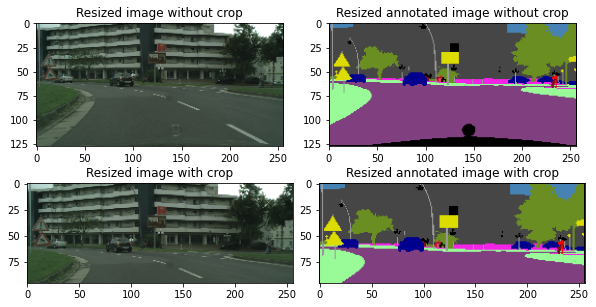

In [10]:
fig, ax = plt.subplots(2, 2, figsize = (10, 5))
ax[0,0].imshow(load_image(train_images_folder_path, train_images_names[0], 128, img_width, crop = False))
ax[0,0].set_title('Resized image without crop')
#ax[0,0].axis('off')

ax[0,1].imshow(load_mask(train_mask_folder_path, train_mask_names[0], 128, img_width, one_hot = False, crop = False))
ax[0,1].set_title('Resized annotated image without crop')
#ax[0,1].axis('off')

ax[1,0].imshow(load_image(train_images_folder_path, train_images_names[0], img_height, img_width))
ax[1,0].set_title('Resized image with crop')
#ax[1,0].axis('off')

ax[1,1].imshow(load_mask(train_mask_folder_path, train_mask_names[0], img_height, img_width, one_hot = False))
ax[1,1].set_title('Resized annotated image with crop')
#ax[1,1].axis('off')

plt.subplots_adjust(wspace = 0.1)
plt.show()

Train


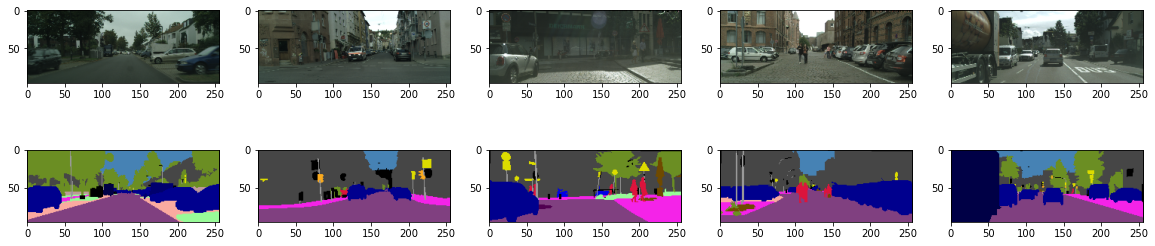

Validation


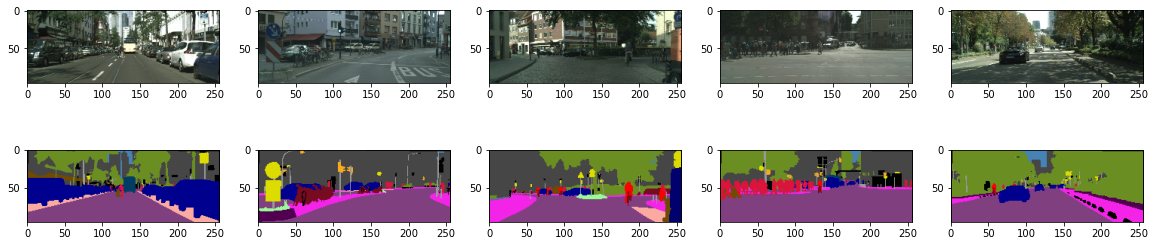

In [11]:
def visualize_image_mask(image_folder, mask_folder, image_paths, mask_paths, img_height = 96, img_width = 256):
    ''' Display 5 random images and their masks.
  
    Arguments:
      - image_folder (string): Path to the image folder
      - mask_folder (string): Path to the mask folder
      - image_paths (string list): Paths to images
      - mask_paths (string list): Paths to masks
      - img_height (int): Height to reshape -- 96
      - img_width (int): Width to reshape -- 256  '''

    idx = np.random.choice(len(image_paths), 5)

    images = [load_image(image_folder, image_paths[i], img_height, img_width) for i in idx]
    masks = [load_mask(mask_folder, mask_paths[i], img_height, img_width, one_hot = False) for i in idx]

    plt.figure(figsize = (20, 5))
    plt.subplots_adjust(hspace = 0.05)

    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.subplot(2, 5, i + 6)
        plt.imshow(masks[i])

    plt.show()

print('Train')
visualize_image_mask(train_images_folder_path, train_mask_folder_path, train_images_names, train_mask_names, img_height = img_height, img_width = img_width)
print('Validation')
visualize_image_mask(val_images_folder_path, val_mask_folder_path, val_images_names, val_mask_names, img_height = img_height, img_width = img_width)

# Check one hot

In [12]:
prueba = load_mask(train_mask_folder_path, train_mask_names[0], 2, 2, one_hot = False)
prueba

<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
array([[[ 70,  70,  70],
        [107, 142,  35]],

       [[128,  64, 128],
        [128,  64, 128]]])>

In [13]:
one_hot_map = []
for color in colors[:5]:
    class_map = tf.reduce_all(tf.equal(prueba, color), axis = -1)
    one_hot_map.append(class_map)

In [14]:
one_hot_map

[<tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>,
 <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>,
 <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>,
 <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [ True,  True]])>,
 <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>]

In [15]:
mask = tf.cast(tf.stack(one_hot_map, axis = -1), tf.int32)
mask

<tf.Tensor: shape=(2, 2, 5), dtype=int32, numpy=
array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]])>

# NN without GDN

U-Net model without generalized division normalization.

In [16]:
def conv_block(inputs, filters, pool = True):
    ''' Define a convolutional block of the encoder.
  
    Arguments:
        - inputs (tf tensor): Input tensor
        - filters (int): Number of filters
        - pool (bool): Do the MaxPooling or not -- True

    Returns:
        - x (tf tensor): Output tensor before the MaxPooling
        - p (tf tensor): Output tensor after the MaxPooling '''

    x = Conv2D(filters, 3, padding = "same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x


def build_unet(shape, num_classes):
    ''' Build an UNET form model.
  
    Arguments:
        - shape ((int, int, int)): Shape of the input tensor
        - num_classes (int): Number of classes

    Returns:
        - model (tf model): Model built '''

    inputs = Input(shape)

    # Encoder
    x1, p1 = conv_block(inputs, 16, pool = True)
    x2, p2 = conv_block(p1, 32, pool = True)
    x3, p3 = conv_block(p2, 48, pool = True)
    x4, p4 = conv_block(p3, 64, pool = True)

    # Bridge
    b1 = conv_block(p4, 128, pool = False)

    # Decoder
    u1 = UpSampling2D((2, 2), interpolation = "bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool = False)

    u2 = UpSampling2D((2, 2), interpolation = "bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool = False)

    u3 = UpSampling2D((2, 2), interpolation = "bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool = False)

    u4 = UpSampling2D((2, 2), interpolation = "bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool = False)

    # Output
    output = Conv2D(num_classes, 1, padding = 'same', activation = 'softmax')(x8)

    return Model(inputs, output)

In [17]:
# Build the model
model1 = build_unet((img_height, img_width, 3), 30)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 256, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 256, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 256, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 256, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
#tf.keras.utils.plot_model(model1)

In [19]:
# Train the model for a small number of epochs to check it works well
lr = 1e-4
epochs = 2

model1.compile(loss = 'categorical_crossentropy', 
               optimizer = tf.keras.optimizers.Adam(learning_rate = lr), 
               metrics = ['accuracy'])

histroy_model1 = model1.fit(train_dataset, 
                            epochs = epochs,
                            verbose = 1)

Epoch 1/2
93/93 [==============================] - 478s 5s/step - loss: 3.0813 - accuracy: 0.3954
Epoch 2/2
93/93 [==============================] - 509s 5s/step - loss: 2.6209 - accuracy: 0.6277


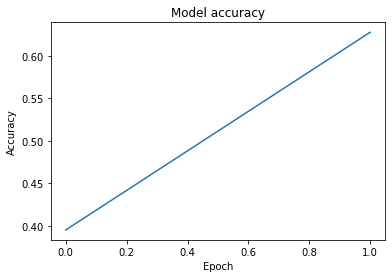

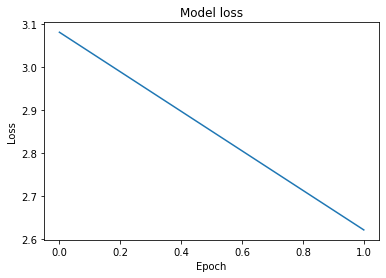

In [20]:
plt.plot(histroy_model1.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(histroy_model1.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Predictions

In [21]:
preds = model1.predict(val_dataset)
preds = np.argmax(preds, axis = 3)

In [22]:
def color_to_one_hot_mask(mask, colors, img_height = 96, img_width = 256):
    ''' Convert from the mask from the classes with highest probablities to the correct color. From (96, 256, 1) to (96, 256, 3).
  
    Arguments:
        - mask (tf tensor): Mask with the classes with highest probabilities
        - colors (list): List with the class colors
        - img_height (int): Height of the images -- 96
        - img_width (int): Width of the images -- 256

    Returns:
        - color_mask (tf tensor): Color mask '''

    color_mask = np.zeros((img_height, img_width, 3)).astype('float')
    for c in range(len(colors)):
        color_true = mask == c
        for i in range(3):
            color_mask[:,:,i] += color_true*colors[c][i]

    color_mask = tf.cast(color_mask, dtype = tf.int32)

    return color_mask


def visualize_image_mask(image_paths, mask_paths, preds, colors, img_height = 96, img_width = 256):
    ''' Display 5 random images, their masks and their predictions.
  
    Arguments:
        - image_paths (string list): Paths to images
        - mask_paths (string list): Paths to masks
        - preds (tf tensor): Model predictions
        - colors (list): Colors list
        - img_height (int): Height to reshape -- 96
        - img_width (int): Width to reshape -- 256  '''

    idx = np.random.choice(len(image_paths), 5)
    print('Val images: ', idx)

    images = [load_image(val_images_folder_path, image_paths[i], img_height, img_width) for i in idx]
    masks = [load_mask(val_mask_folder_path, mask_paths[i], img_height, img_width, one_hot = False) for i in idx]
    preds = preds[idx]

    plt.figure(figsize = (20, 5))
    plt.subplots_adjust(hspace = 0.05)

    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i])
        plt.subplot(3, 5, i + 6)
        plt.imshow(masks[i])
        plt.subplot(3, 5, i + 11)
        plt.imshow(color_to_one_hot_mask(preds[i], colors))

    plt.show()

Val images:  [298 166 426 313 122]


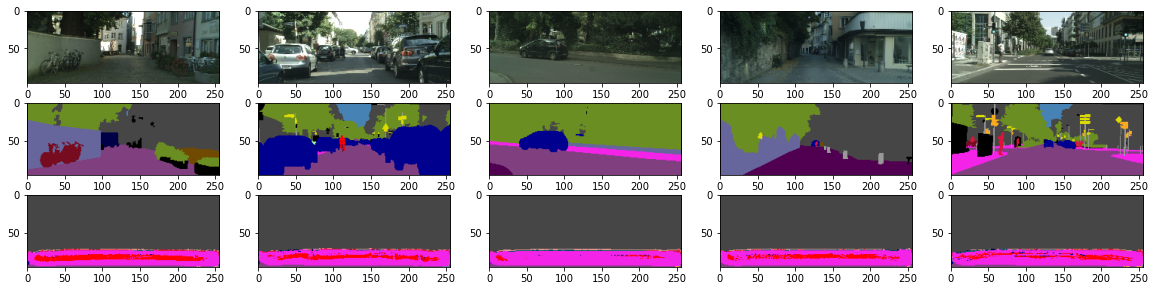

In [23]:
visualize_image_mask(val_images_names, val_mask_names, preds, colors, img_height = 96, img_width = 256)

In [24]:
y_real_oh[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 7, ..., 0, 0, 0],
       [0, 0, 7, ..., 0, 0, 0],
       ...,
       [0, 3, 3, ..., 4, 4, 0],
       [0, 3, 3, ..., 4, 4, 0],
       [0, 3, 3, ..., 4, 4, 0]], dtype=int64)

In [25]:
preds[0]

array([[ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  7,  7,  7],
       ...,
       [ 4,  3,  3, ...,  4, 29, 18],
       [21, 21,  3, ...,  9, 18, 18],
       [ 9,  3,  3, ...,  3,  3, 11]], dtype=int64)

In [26]:
def iou_metrics(y_true, y_pred):
    ''' Calculate the intersection over union metric for each class for one image.
  
    Arguments:
        - y_true (tf tensor): Real mask the classes with highest probabilities (height, width, 1)
        - y_pred (tf tensor): Predicted mask the classes with highest probabilities (height, width, 1)

    Returns:
        - class_iou (list): Iou for each class '''

    class_iou = []
    smoothening_factor = 0.00001

    for i in range(len(names)):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        if iou < 10**(-5):
            iou = 0
        class_iou.append(iou)

    return class_iou


iou = []
for i in range(len(preds)):
    iou.append(iou_metrics(y_real_oh[i], preds[i]))

In [27]:
# Iou per class
pd.DataFrame({'Names': names, 'IOU': [iou for iou in np.mean(iou, axis = 0)]})

,Names,IOU
0,unlabeled,0.000577
1,dynamic,0.472000
2,ground,0.330010
3,road,0.073104
4,sidewalk,0.088229
5,parking,0.780000
6,rail track,0.000201
7,building,0.329947
8,wall,0.596000
9,fence,0.004013


In [28]:
# Mean IoU
np.mean(iou)

0.3222086266017411

# Hyperparameter turning

Check the best learning rate

In [20]:
train_dataset_hpt = tf.data.Dataset.from_tensor_slices((train_images_names[:1000], train_mask_names[:1000]))
train_dataset_hpt = train_dataset_hpt.map(load_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset_hpt = train_dataset_hpt.batch(batch_size)
train_dataset_hpt

<BatchDataset shapes: ((None, 96, 256, 3), (None, 96, 256, 30)), types: (tf.float32, tf.int32)>

In [21]:
model_hpt_1 = build_unet((img_height, img_width, 3), 30)
model_hpt_2 = build_unet((img_height, img_width, 3), 30)
model_hpt_3 = build_unet((img_height, img_width, 3), 30)

In [22]:
lr_1, lr_2, lr_3 = 1e-5, 1e-4, 1e-3
epochs = 20

model_hpt_1.compile(loss = 'categorical_crossentropy', 
                    optimizer = tf.keras.optimizers.Adam(learning_rate = lr_1), 
                    metrics = ['accuracy'])

model_hpt_2.compile(loss = 'categorical_crossentropy', 
                    optimizer = tf.keras.optimizers.Adam(learning_rate = lr_2), 
                    metrics = ['accuracy'])

model_hpt_3.compile(loss = 'categorical_crossentropy', 
                    optimizer = tf.keras.optimizers.Adam(learning_rate = lr_3), 
                    metrics = ['accuracy'])

In [23]:
histroy_model_hpt_1 = model_hpt_1.fit(train_dataset_hpt, 
                                      epochs = epochs,
                                      verbose = 1)

Epoch 1/20
32/32 [==============================] - 158s 5s/step - loss: 3.8914 - accuracy: 0.0342
Epoch 2/20
32/32 [==============================] - 159s 5s/step - loss: 3.8011 - accuracy: 0.0541
Epoch 3/20
32/32 [==============================] - 159s 5s/step - loss: 3.7319 - accuracy: 0.0746
Epoch 4/20
32/32 [==============================] - 159s 5s/step - loss: 3.6795 - accuracy: 0.0959
Epoch 5/20
32/32 [==============================] - 156s 5s/step - loss: 3.6338 - accuracy: 0.1206
Epoch 6/20
32/32 [==============================] - 153s 5s/step - loss: 3.5882 - accuracy: 0.1381
Epoch 7/20
32/32 [==============================] - 152s 5s/step - loss: 3.5423 - accuracy: 0.1468
Epoch 8/20
32/32 [==============================] - 153s 5s/step - loss: 3.5001 - accuracy: 0.1534
Epoch 9/20
32/32 [==============================] - 153s 5s/step - loss: 3.4639 - accuracy: 0.1597
Epoch 10/20
32/32 [==============================] - 155s 5s/step - loss: 3.4320 - accuracy: 0.1658
Epoch 11/

In [24]:
histroy_model_hpt_2 = model_hpt_2.fit(train_dataset_hpt, 
                                      epochs = epochs,
                                      verbose = 1)

Epoch 1/20
32/32 [==============================] - 163s 5s/step - loss: 3.5926 - accuracy: 0.1225
Epoch 2/20
32/32 [==============================] - 161s 5s/step - loss: 3.2193 - accuracy: 0.1925
Epoch 3/20
32/32 [==============================] - 161s 5s/step - loss: 2.9728 - accuracy: 0.2366
Epoch 4/20
32/32 [==============================] - 161s 5s/step - loss: 2.8027 - accuracy: 0.3389
Epoch 5/20
32/32 [==============================] - 159s 5s/step - loss: 2.6763 - accuracy: 0.4044
Epoch 6/20
32/32 [==============================] - 155s 5s/step - loss: 2.5979 - accuracy: 0.4665
Epoch 7/20
32/32 [==============================] - 155s 5s/step - loss: 2.5352 - accuracy: 0.5647
Epoch 8/20
32/32 [==============================] - 155s 5s/step - loss: 2.4812 - accuracy: 0.6097
Epoch 9/20
32/32 [==============================] - 155s 5s/step - loss: 2.4314 - accuracy: 0.6240
Epoch 10/20
32/32 [==============================] - 154s 5s/step - loss: 2.3850 - accuracy: 0.6322
Epoch 11/

In [25]:
histroy_model_hpt_3 = model_hpt_3.fit(train_dataset_hpt, 
                                      epochs = epochs,
                                      verbose = 1)

Epoch 1/20
32/32 [==============================] - 156s 5s/step - loss: 2.7739 - accuracy: 0.4474
Epoch 2/20
32/32 [==============================] - 154s 5s/step - loss: 2.1926 - accuracy: 0.6241
Epoch 3/20
32/32 [==============================] - 154s 5s/step - loss: 1.8877 - accuracy: 0.6480
Epoch 4/20
32/32 [==============================] - 155s 5s/step - loss: 1.6577 - accuracy: 0.6647
Epoch 5/20
32/32 [==============================] - 154s 5s/step - loss: 1.4891 - accuracy: 0.6943
Epoch 6/20
32/32 [==============================] - 154s 5s/step - loss: 1.3658 - accuracy: 0.7287
Epoch 7/20
32/32 [==============================] - 154s 5s/step - loss: 1.2917 - accuracy: 0.7362
Epoch 8/20
32/32 [==============================] - 155s 5s/step - loss: 1.2407 - accuracy: 0.7467
Epoch 9/20
32/32 [==============================] - 154s 5s/step - loss: 1.2170 - accuracy: 0.7455
Epoch 10/20
32/32 [==============================] - 154s 5s/step - loss: 1.1707 - accuracy: 0.7514
Epoch 11/

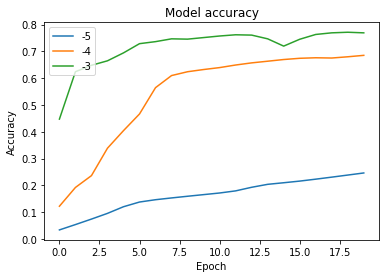

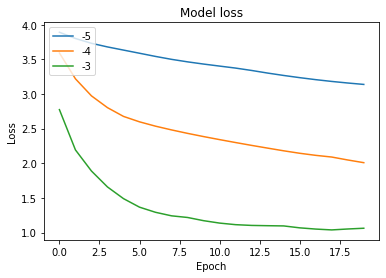

In [26]:
plt.plot(histroy_model_hpt_1.history['accuracy'])
plt.plot(histroy_model_hpt_2.history['accuracy'])
plt.plot(histroy_model_hpt_3.history['accuracy'])
plt.legend(['-5', '-4', '-3'], loc = 'upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(histroy_model_hpt_1.history['loss'])
plt.plot(histroy_model_hpt_2.history['loss'])
plt.plot(histroy_model_hpt_3.history['loss'])
plt.legend(['-5', '-4', '-3'], loc = 'upper left')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Train for many epochs

In [ ]:
lr = 1e-4
epochs = 100
checkpoint_filepath = './tmp/weights.{epoch:02d}-{accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, 
                                                               save_weights_only = True, 
                                                               monitor = 'accuracy',
                                                               mode = 'max',
                                                               save_best_only = True,
                                                               verbose = 0)

model1.compile(loss = 'categorical_crossentropy', 
               optimizer = tf.keras.optimizers.Adam(learning_rate = lr), 
               metrics = ['accuracy'])

history_model1 = model1.fit(train_dataset, 
                            epochs = epochs,
                            verbose = 1,
                            callbacks = [model_checkpoint_callback])

Epoch 1/100
93/93 [==============================] - 461s 5s/step - loss: 2.2961 - accuracy: 0.6861
Epoch 2/100
93/93 [==============================] - 465s 5s/step - loss: 2.1738 - accuracy: 0.7055
Epoch 3/100
93/93 [==============================] - 460s 5s/step - loss: 2.0635 - accuracy: 0.7158
Epoch 4/100
93/93 [==============================] - 459s 5s/step - loss: 1.9612 - accuracy: 0.7239
Epoch 5/100
93/93 [==============================] - 460s 5s/step - loss: 1.8660 - accuracy: 0.7309
Epoch 6/100
93/93 [==============================] - 471s 5s/step - loss: 1.7781 - accuracy: 0.7377
Epoch 7/100
93/93 [==============================] - 458s 5s/step - loss: 1.6972 - accuracy: 0.7443
Epoch 8/100
93/93 [==============================] - 462s 5s/step - loss: 1.6248 - accuracy: 0.7496
Epoch 9/100
93/93 [==============================] - 447s 5s/step - loss: 1.5609 - accuracy: 0.7537
Epoch 10/100
93/93 [==============================] - 446s 5s/step - loss: 1.5061 - accuracy: 0.7565

In [ ]:
plt.plot(history_model1.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(history_model1.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model1.load_weights(checkpoint_filepath)

preds = model1.predict(val_dataset)
preds = np.argmax(preds, axis = 3)

In [ ]:
visualize_image_mask(val_images_names, val_mask_names, preds, colors, img_height = 96, img_width = 256)

# Define GDN layer

# NN with GDN

U-Net model with generalized division normalization.

En principio esto no se puede usar tal cual en windows...

In [ ]:
!pip install tensorflow-compression

     |████████████████████████████████| 211 kB 8.3 MB/s 
     |████████████████████████████████| 28.5 MB 33 kB/s 
     |████████████████████████████████| 4.8 MB 57.6 MB/s 
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.13.0
    Uninstalling tensorflow-probability-0.13.0:
      Successfully uninstalled tensorflow-probability-0.13.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from tensorflow_compression import GDN

In [ ]:
def build_unet_gdn(shape, num_classes):
    ''' Build an UNET form model with GDN layers between the convolutional blocks of the encoder.
  
    Arguments:
        - shape ((int, int, int)): Shape of the input tensor
        - num_classes (int): Number of classes

    Returns:
        - model (tf model): Model built '''
    
    inputs = Input(shape)

    # Encoder
    x1, p1 = conv_block(inputs, 16, pool = True)
    p1_1 = GDN()(p1)
    x2, p2 = conv_block(p1_1, 32, pool = True)
    p2_2 = GDN()(p2)
    x3, p3 = conv_block(p2_2, 48, pool = True)
    p3_3 = GDN()(p3)
    x4, p4 = conv_block(p3_3, 64, pool = True)

    # Bridge
    b1 = conv_block(p4, 128, pool = False)

    # Decoder
    u1 = UpSampling2D((2, 2), interpolation = "bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool = False)

    u2 = UpSampling2D((2, 2), interpolation = "bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool = False)

    u3 = UpSampling2D((2, 2), interpolation = "bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool = False)

    u4 = UpSampling2D((2, 2), interpolation = "bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool = False)

    # Output
    output = Conv2D(num_classes, 1, padding = 'same', activation = 'softmax')(x8)

    return Model(inputs, output)

# Build the model
model_2 = build_unet_gdn((128, 256, 3), 30)
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 256, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 128, 256, 16) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [ ]:
# Train the model for a small number of epochs
lr = 1e-4
epochs = 10

model_2.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = lr))

model_2.fit(dataset, epochs = epochs)

Epoch 1/10
2/2 [==============================] - 11s 2s/step - loss: 3.7782
Epoch 2/10
2/2 [==============================] - 7s 2s/step - loss: 3.6861
Epoch 3/10
2/2 [==============================] - 7s 2s/step - loss: 3.6269
Epoch 4/10
2/2 [==============================] - 6s 2s/step - loss: 3.5792
Epoch 5/10
2/2 [==============================] - 6s 2s/step - loss: 3.5374
Epoch 6/10
2/2 [==============================] - 6s 2s/step - loss: 3.4990
Epoch 7/10
2/2 [==============================] - 7s 1s/step - loss: 3.4643
Epoch 8/10
2/2 [==============================] - 7s 2s/step - loss: 3.4329
Epoch 9/10
2/2 [==============================] - 7s 2s/step - loss: 3.4043
Epoch 10/10
2/2 [==============================] - 7s 2s/step - loss: 3.3773
